In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,data.shape[3],1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

def resize_par(data, factor):
    test =  np.zeros((data.shape[0], data.shape[1],data.shape[2],data.shape[3]//factor))
    print(data.shape, test.shape)
    for i in range(6):
        test[:,i,:,:] = downscale_local_mean(data[:,i,:,:], (1,1,factor))
    return test


/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
plate = np.load('../../real_filtered.npy')[:12000]
print(plate.shape)

(12000, 6, 16, 2048)


In [3]:
%matplotlib inline
NUM_SAMPLES = 10000

print(plate.shape)
print("Creating True")
data = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=10, factor =1)
print(data.shape)
data = resize_par(data, factor=8)
data = combine(load_data_ED(data))
print(data.shape)

print("Creating False")
false_data = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=10))
false_data = resize_par(false_data, factor=8)
false_data = load_data_ED(false_data)


print("Creating True")
true_data_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_1 = resize_par(true_data_1, factor=8)
true_data_1 = load_data_ED(true_data_1)

true_data_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_2 = resize_par(true_data_2, factor=8)
true_data_2 = load_data_ED(true_data_2)

true_data = np.concatenate((true_data_1,true_data_2),axis=0)
print(true_data.shape)

del true_data_1,true_data_2
gc.collect()

(12000, 6, 16, 2048)
Creating True
(10000, 6, 16, 2048)
(10000, 6, 16, 2048) (10000, 6, 16, 256)
(10000, 6, 16, 256)
(60000, 16, 256, 1)
Creating False
(60000, 6, 16, 2048) (60000, 6, 16, 256)
(60000, 6, 16, 256)
Creating True
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(30000, 6, 16, 2048) (30000, 6, 16, 256)
(30000, 6, 16, 256)
(60000, 6, 16, 256, 1)


31174

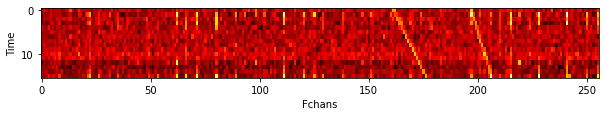

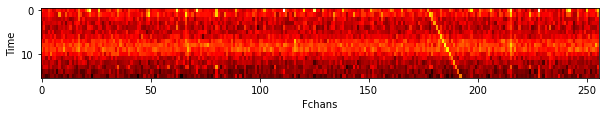

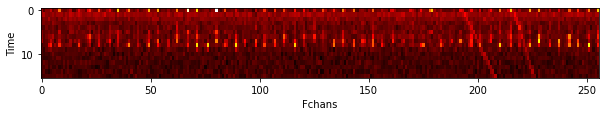

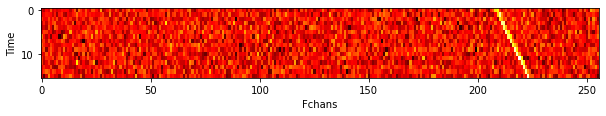

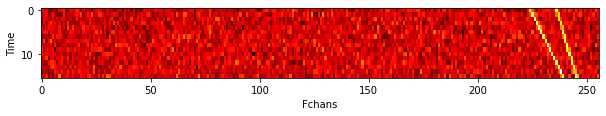

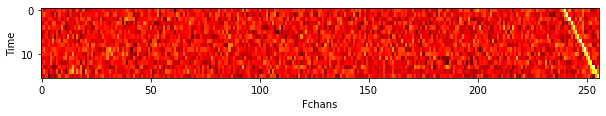

In [4]:
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[0,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

In [5]:
NUM_SAMPLES = 1000

print(plate.shape)
print("Creating True")
data_test = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=10, factor =1)
data_test = resize_par(data_test, factor=8)
data_test = combine(load_data_ED(data_test))

print("Creating False")
false_data_test = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=10))
false_data_test = resize_par(false_data_test, factor=8)
false_data_test = load_data_ED(false_data_test)


print("Creating True")
true_data_test_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_test_1 = resize_par(true_data_test_1, factor=8)
true_data_test_1 = load_data_ED(true_data_test_1)

true_data_test_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=10, factor =1)
true_data_test_2 = resize_par(true_data_test_2, factor=8)
true_data_test_2 = load_data_ED(true_data_test_2)


true_data_test = np.concatenate((true_data_test_1,true_data_test_2),axis=0)
print(true_data_test.shape)
del true_data_test_1,true_data_test_2
gc.collect()

(12000, 6, 16, 2048)
Creating True
(1000, 6, 16, 2048) (1000, 6, 16, 256)
(1000, 6, 16, 256)
Creating False
(6000, 6, 16, 2048) (6000, 6, 16, 256)
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(3000, 6, 16, 2048) (3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)


16090

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha=10, beta=2, gamma = 10, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.true_score_tracker = keras.metrics.Mean(name="true_score")
        self.false_score_tracker = keras.metrics.Mean(name="false_score")
        
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        self.true_score_tracker_validation = keras.metrics.Mean(name="true_score")
        self.false_score_tracker_validation = keras.metrics.Mean(name="false_score")
        
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += (difference - same)/same
        else:
            similarity += (difference - same)/difference
 
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def false_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += -(difference - same)/same
        else:
            similarity += -(difference - same)/difference
        
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )/(16*256)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            
#             false_score = self.false_score(false_data)
#             true_score = self.true_score(true_data)
            false_score =0
            true_score = 0
            
            total_loss = reconstruction_loss/(16*256) + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        
        self.false_score_tracker.update_state(false_score)
        self.true_score_tracker.update_state(true_score)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result(),
            "false_score": self.false_score_tracker.result(),
            "true_score": self.true_score_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )/(16*256)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
#         false_score = self.false_score(false_data)
#         true_score = self.true_score(true_data)
        false_score = 0
        true_score =0
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        self.false_score_tracker_validation.update_state(false_score)
        self.true_score_tracker_validation.update_state(true_score)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result(),
            "false_score": self.false_score_tracker_validation.result(),
            "true_score": self.true_score_tracker_validation.result()
        }

In [24]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [25]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [26]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [41]:
def build_model(latent_dim=8,dens_lay=512, kernel=(3,3), alpha=10, beta=2, gamma=10):
    
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=l1(0.001),
                          kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var" , activity_regularizer=l1(0.001),
                             kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001), 
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(latent_inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(1* 16 * 256, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Reshape((1,16, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder, alpha, beta, gamma)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

alpha, beta, gamma = 1,1,0
latent_dim=8
dens_lay=512
kernel=(3,3)


model_num = 46
name = "VAE-ENCODER_compressed_256v%d"%(model_num)
print(name)

print("Model " +name+": \(\\alpha : %3d\),  \(\\beta : %3d\),  \(\gamma : %3d\), latent_dim:%3d, dense:%3d " % (alpha, beta, gamma, latent_dim, dens_lay))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
VAE-ENCODER_compressed_256v46
Model VAE-ENCODER_compressed_256v46: \(\alpha :   1\),  \(\beta :   1\),  \(\gamma :   0\), latent_dim:  8, dense:512 
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 16, 256, 1)] 0                                            
______________________________________

In [42]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.hdf5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

history = model.fit(x = [data, true_data, false_data], y= data[:,:,:,:], epochs=200, batch_size=2000, 
          validation_data=([data_test, true_data_test, false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/200
30/30 [==============================] - 62s 1s/step - loss: 511.3747 - reconstruction_loss: 0.6814 - kl_loss: 9.8045 - false_loss: 28.8152 - true_loss: 20.8175 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 298.7301 - val_reconstruction_loss: 0.6630 - val_kl_loss: 8.6131 - val_false_loss: 12.2915 - val_true_loss: 15.7926 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 2/200
30/30 [==============================] - 18s 608ms/step - loss: 295.0898 - reconstruction_loss: 0.6442 - kl_loss: 9.8547 - false_loss: 15.2609 - true_loss: 18.2113 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 296.3039 - val_reconstruction_loss: 0.6475 - val_kl_loss: 9.1032 - val_false_loss: 11.4115 - val_true_loss: 16.3335 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 3/200
30/30 [==============================] - 20s 659ms/step - loss: 292.6560 - reconstruction_loss: 0.6349 - kl_loss: 9.8909 - false_loss: 13.1784 - true_loss: 17.7708

Epoch 21/200
30/30 [==============================] - 20s 671ms/step - loss: 263.7243 - reconstruction_loss: 0.6332 - kl_loss: 11.0813 - false_loss: 9.7216 - true_loss: 16.8759 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 281.7868 - val_reconstruction_loss: 0.6316 - val_kl_loss: 10.1971 - val_false_loss: 9.4876 - val_true_loss: 16.5885 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 22/200
30/30 [==============================] - 20s 673ms/step - loss: 260.8306 - reconstruction_loss: 0.6332 - kl_loss: 11.6227 - false_loss: 9.6325 - true_loss: 16.8400 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 281.0277 - val_reconstruction_loss: 0.6315 - val_kl_loss: 10.3262 - val_false_loss: 9.3728 - val_true_loss: 16.6016 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 23/200
30/30 [==============================] - 20s 678ms/step - loss: 260.9860 - reconstruction_loss: 0.6332 - kl_loss: 11.7957 - false_loss: 9.5447 - true_loss: 1

Epoch 41/200
30/30 [==============================] - 20s 667ms/step - loss: 221.1766 - reconstruction_loss: 0.6315 - kl_loss: 21.6917 - false_loss: 8.5657 - true_loss: 16.3357 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 269.6717 - val_reconstruction_loss: 0.6300 - val_kl_loss: 11.6497 - val_false_loss: 8.4041 - val_true_loss: 16.1701 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 42/200
30/30 [==============================] - 20s 665ms/step - loss: 176.7002 - reconstruction_loss: 0.6303 - kl_loss: 23.5385 - false_loss: 8.4697 - true_loss: 16.1670 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 267.1998 - val_reconstruction_loss: 0.6299 - val_kl_loss: 11.9418 - val_false_loss: 8.2929 - val_true_loss: 15.9757 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 43/200
30/30 [==============================] - 20s 666ms/step - loss: 160.8617 - reconstruction_loss: 0.6296 - kl_loss: 24.7265 - false_loss: 8.3585 - true_loss: 1

Epoch 61/200
30/30 [==============================] - 20s 665ms/step - loss: 127.6939 - reconstruction_loss: 0.6174 - kl_loss: 25.7926 - false_loss: 6.6405 - true_loss: 12.9793 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 226.7027 - val_reconstruction_loss: 0.6265 - val_kl_loss: 16.3351 - val_false_loss: 6.4810 - val_true_loss: 12.8596 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 62/200
30/30 [==============================] - 20s 668ms/step - loss: 126.1126 - reconstruction_loss: 0.6174 - kl_loss: 25.8704 - false_loss: 6.5692 - true_loss: 12.8535 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 225.1100 - val_reconstruction_loss: 0.6263 - val_kl_loss: 16.4898 - val_false_loss: 6.4126 - val_true_loss: 12.7378 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 63/200
30/30 [==============================] - 20s 667ms/step - loss: 126.8424 - reconstruction_loss: 0.6169 - kl_loss: 25.7922 - false_loss: 6.5002 - true_loss: 1

Epoch 81/200
30/30 [==============================] - 20s 669ms/step - loss: 117.4896 - reconstruction_loss: 0.6161 - kl_loss: 25.5477 - false_loss: 5.5096 - true_loss: 10.9843 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 201.3904 - val_reconstruction_loss: 0.6230 - val_kl_loss: 18.7622 - val_false_loss: 5.3770 - val_true_loss: 10.9473 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 82/200
30/30 [==============================] - 20s 668ms/step - loss: 116.9584 - reconstruction_loss: 0.6158 - kl_loss: 25.5811 - false_loss: 5.4653 - true_loss: 10.9073 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 200.4369 - val_reconstruction_loss: 0.6229 - val_kl_loss: 18.8631 - val_false_loss: 5.3334 - val_true_loss: 10.8754 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 83/200
30/30 [==============================] - 20s 671ms/step - loss: 117.6122 - reconstruction_loss: 0.6160 - kl_loss: 25.4931 - false_loss: 5.4222 - true_loss: 1

Epoch 101/200
30/30 [==============================] - 20s 675ms/step - loss: 111.1880 - reconstruction_loss: 0.6159 - kl_loss: 24.8377 - false_loss: 4.7684 - true_loss: 9.7180 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 185.0255 - val_reconstruction_loss: 0.6208 - val_kl_loss: 20.1026 - val_false_loss: 4.6700 - val_true_loss: 9.7499 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 102/200
30/30 [==============================] - 20s 673ms/step - loss: 110.6639 - reconstruction_loss: 0.6158 - kl_loss: 24.8031 - false_loss: 4.7374 - true_loss: 9.6664 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 184.3403 - val_reconstruction_loss: 0.6207 - val_kl_loss: 20.1500 - val_false_loss: 4.6412 - val_true_loss: 9.7007 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 103/200
30/30 [==============================] - 20s 675ms/step - loss: 110.1371 - reconstruction_loss: 0.6157 - kl_loss: 24.7140 - false_loss: 4.7069 - true_loss: 9.

Epoch 121/200
30/30 [==============================] - 20s 666ms/step - loss: 105.4289 - reconstruction_loss: 0.6159 - kl_loss: 22.2549 - false_loss: 4.2570 - true_loss: 8.8459 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 173.1967 - val_reconstruction_loss: 0.6193 - val_kl_loss: 20.7671 - val_false_loss: 4.1973 - val_true_loss: 8.9071 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 122/200
30/30 [==============================] - 20s 670ms/step - loss: 105.6484 - reconstruction_loss: 0.6158 - kl_loss: 22.1833 - false_loss: 4.2366 - true_loss: 8.8093 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 172.6725 - val_reconstruction_loss: 0.6192 - val_kl_loss: 20.7857 - val_false_loss: 4.1776 - val_true_loss: 8.8705 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 123/200
30/30 [==============================] - 20s 670ms/step - loss: 103.8368 - reconstruction_loss: 0.6159 - kl_loss: 22.0615 - false_loss: 4.2158 - true_loss: 8.

Epoch 141/200
30/30 [==============================] - 20s 668ms/step - loss: 98.1922 - reconstruction_loss: 0.6160 - kl_loss: 21.2725 - false_loss: 3.8887 - true_loss: 8.1771 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 163.9114 - val_reconstruction_loss: 0.6182 - val_kl_loss: 21.0151 - val_false_loss: 3.8560 - val_true_loss: 8.2703 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 142/200
30/30 [==============================] - 20s 667ms/step - loss: 99.0149 - reconstruction_loss: 0.6160 - kl_loss: 21.2266 - false_loss: 3.8728 - true_loss: 8.1476 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 163.5181 - val_reconstruction_loss: 0.6181 - val_kl_loss: 21.0365 - val_false_loss: 3.8407 - val_true_loss: 8.2420 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 143/200
30/30 [==============================] - 20s 667ms/step - loss: 98.9329 - reconstruction_loss: 0.6160 - kl_loss: 21.3838 - false_loss: 3.8570 - true_loss: 8.118

Epoch 161/200
30/30 [==============================] - 20s 668ms/step - loss: 96.4984 - reconstruction_loss: 0.6162 - kl_loss: 20.7648 - false_loss: 3.6072 - true_loss: 7.6520 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 156.8333 - val_reconstruction_loss: 0.6174 - val_kl_loss: 21.1330 - val_false_loss: 3.6054 - val_true_loss: 7.7896 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 162/200
30/30 [==============================] - 20s 669ms/step - loss: 100.2681 - reconstruction_loss: 0.6162 - kl_loss: 20.8787 - false_loss: 3.5957 - true_loss: 7.6296 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 156.5230 - val_reconstruction_loss: 0.6174 - val_kl_loss: 21.1433 - val_false_loss: 3.5940 - val_true_loss: 7.7679 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 163/200
30/30 [==============================] - 20s 668ms/step - loss: 95.6391 - reconstruction_loss: 0.6163 - kl_loss: 20.8556 - false_loss: 3.5833 - true_loss: 7.60

Epoch 181/200
30/30 [==============================] - 20s 670ms/step - loss: 92.6359 - reconstruction_loss: 0.6164 - kl_loss: 20.3773 - false_loss: 3.3832 - true_loss: 7.2256 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 151.2248 - val_reconstruction_loss: 0.6168 - val_kl_loss: 21.2158 - val_false_loss: 3.4109 - val_true_loss: 7.4068 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 182/200
30/30 [==============================] - 20s 671ms/step - loss: 93.0125 - reconstruction_loss: 0.6165 - kl_loss: 20.3054 - false_loss: 3.3731 - true_loss: 7.2062 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 150.9841 - val_reconstruction_loss: 0.6168 - val_kl_loss: 21.2151 - val_false_loss: 3.4033 - val_true_loss: 7.3904 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 183/200
30/30 [==============================] - 20s 668ms/step - loss: 93.8784 - reconstruction_loss: 0.6165 - kl_loss: 20.2342 - false_loss: 3.3633 - true_loss: 7.187

In [37]:
model.encoder.save(name+"gamma.h5")

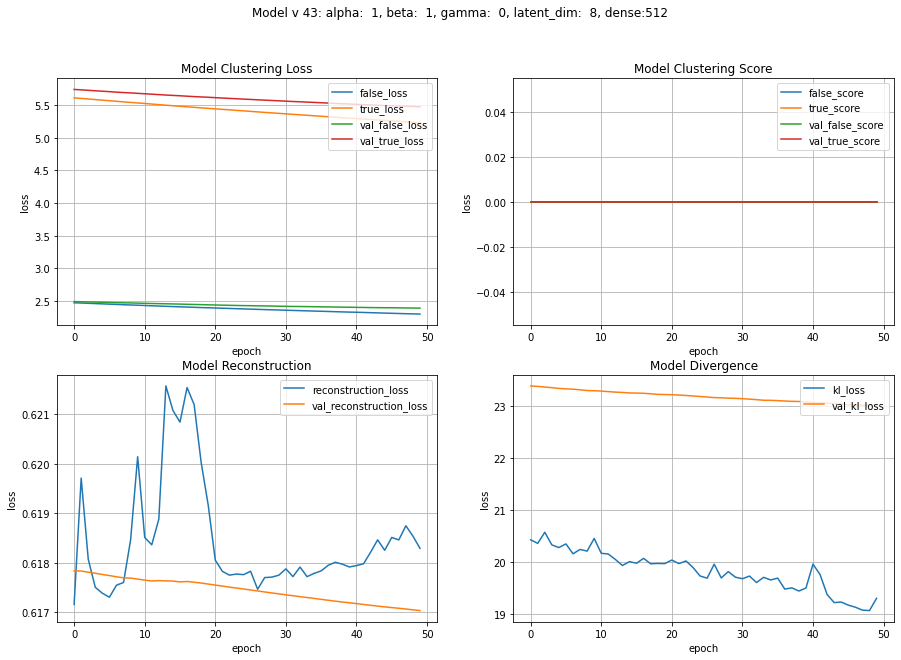

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))

fig.suptitle("Model v%3d: alpha:%3d, beta:%3d, gamma:%3d, latent_dim:%3d, dense:%3d " % (model_num, alpha, beta, gamma, latent_dim, dens_lay))

ax1.plot(history.history['false_loss'])
ax1.plot(history.history['true_loss'])
ax1.plot(history.history['val_false_loss'])
ax1.plot(history.history['val_true_loss'])
ax1.set_title('Model Clustering Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['false_loss', 'true_loss','val_false_loss','val_true_loss'], loc='upper right')
ax1.grid()

ax2.plot(history.history['false_score'])
ax2.plot(history.history['true_score'])
ax2.plot(history.history['val_false_score'])
ax2.plot(history.history['val_true_score'])
ax2.set_title('Model Clustering Score')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['false_score', 'true_score','val_false_score','val_true_score'], loc='upper right')
ax2.grid()

ax3.plot(history.history['reconstruction_loss'])
ax3.plot(history.history['val_reconstruction_loss'])
ax3.set_title('Model Reconstruction')
ax3.set_ylabel('loss')
ax3.set_xlabel('epoch')
ax3.legend(['reconstruction_loss', 'val_reconstruction_loss'], loc='upper right')
ax3.grid()


ax4.plot(history.history['kl_loss'])
ax4.plot(history.history['val_kl_loss'])
ax4.set_title('Model Divergence')
ax4.set_ylabel('loss')
ax4.set_xlabel('epoch')
ax4.legend(['kl_loss', 'val_kl_loss'], loc='upper right')
ax4.grid()
fig.savefig(name+'.png')

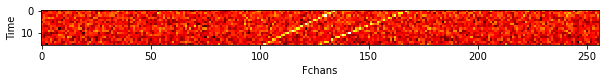

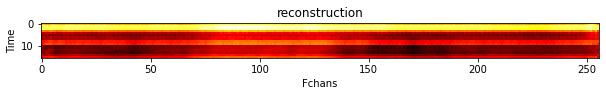

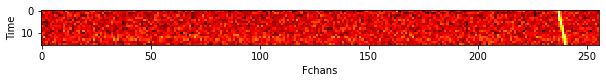

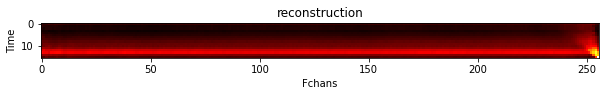

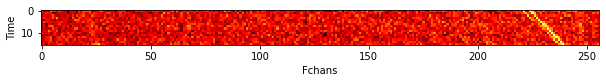

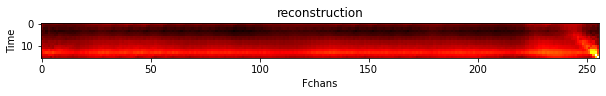

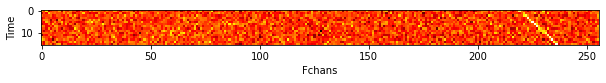

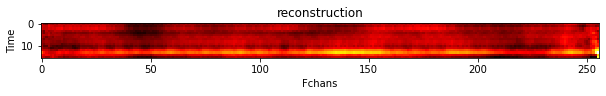

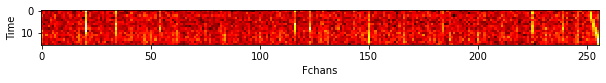

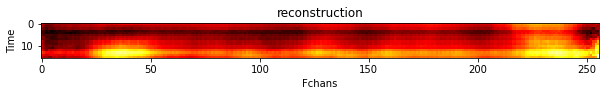

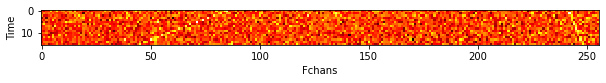

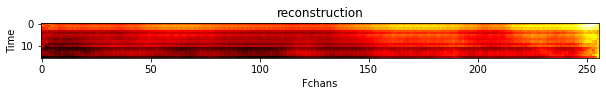

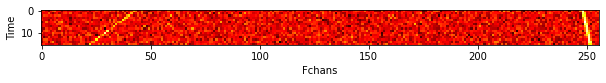

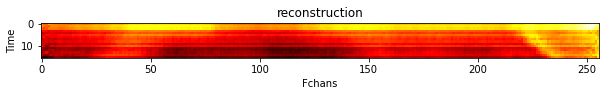

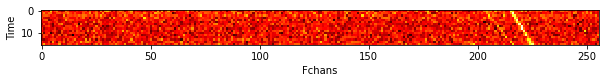

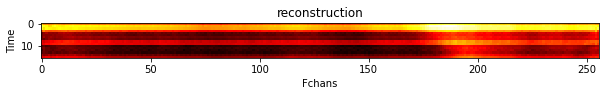

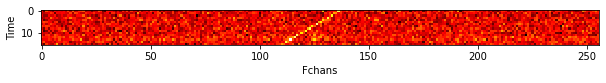

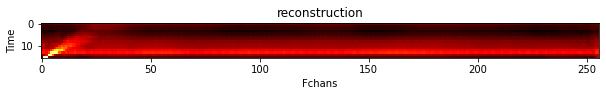

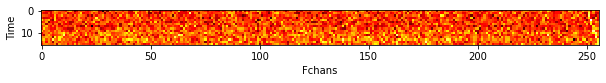

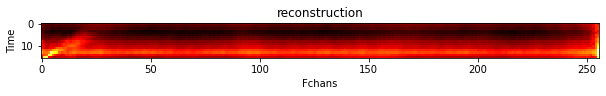

In [14]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
